In [6]:
import os
import torch
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            return torch.argmax(x, 1)


os.environ['WANDB_NOTEBOOK_NAME'] = '9.实验-手写数字识别实验.ipynb'

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random

# 设置全局随机种子
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)


class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


transform = transforms.Compose([
    transforms.RandomRotation(12),  # 随机旋转 12 度
    transforms.ToTensor()
])

# 加载训练数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)


# 定义训练数据加载器
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)

In [32]:
import wandb

wandb.require("core")

model = Net()
epochs = 6
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb_init_args = {
    'project': 'MNIST-手写数字识别',
    'config': {
        "learning_rate": learning_rate,
        "architecture": "ANN",
        "dataset": "MNIST",
        "epochs": epochs,
    },
}
run = wandb.init(**wandb_init_args, job_type="training")
wandb_init_args['name'] = run.name
wandb.watch(model, log="all")


for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        loss.backward()
        optimizer.step()
        if (i + 1) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, epochs, i + 1, len(train_dataset) // 64, loss.item()))
    wandb.log({"loss": loss.item(), "acc": acc.item()}, step=epoch)

wandb.finish()

Epoch [1/6], Iter [100/937] Loss: 0.7270
Epoch [1/6], Iter [200/937] Loss: 0.3535
Epoch [1/6], Iter [300/937] Loss: 0.3401
Epoch [1/6], Iter [400/937] Loss: 0.1860
Epoch [1/6], Iter [500/937] Loss: 0.2612
Epoch [1/6], Iter [600/937] Loss: 0.1362
Epoch [1/6], Iter [700/937] Loss: 0.3081
Epoch [1/6], Iter [800/937] Loss: 0.0832
Epoch [1/6], Iter [900/937] Loss: 0.2130
Epoch [2/6], Iter [100/937] Loss: 0.2794
Epoch [2/6], Iter [200/937] Loss: 0.2336
Epoch [2/6], Iter [300/937] Loss: 0.1204
Epoch [2/6], Iter [400/937] Loss: 0.1863
Epoch [2/6], Iter [500/937] Loss: 0.1862
Epoch [2/6], Iter [600/937] Loss: 0.1922
Epoch [2/6], Iter [700/937] Loss: 0.1263
Epoch [2/6], Iter [800/937] Loss: 0.1786
Epoch [2/6], Iter [900/937] Loss: 0.1017
Epoch [3/6], Iter [100/937] Loss: 0.0643
Epoch [3/6], Iter [200/937] Loss: 0.0537
Epoch [3/6], Iter [300/937] Loss: 0.0493
Epoch [3/6], Iter [400/937] Loss: 0.0621
Epoch [3/6], Iter [500/937] Loss: 0.0450
Epoch [3/6], Iter [600/937] Loss: 0.2276
Epoch [3/6], Ite

acc,▁█▅█▅█
loss,█▃▇▁▇▂
acc,0.96875
loss,0.06915


In [41]:
# 保存后加载模型
torch.save(model.state_dict(), 'model_five_2.0.pth')
# net = Net()
# net.load_state_dict(torch.load('model.pth'))

{0: 6, 1: 9, 2: 16, 3: 19, 4: 20, 5: 13, 6: 14, 7: 27, 8: 28, 9: 30}
error-count: 182
Accuracy of the network on the 10000 test images: 98.18%


test_accuracy,▁
test_loss,▁
test_accuracy,0.9818
test_loss,0.0575


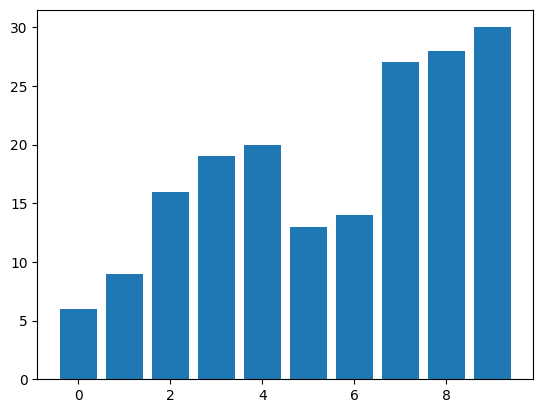

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

wandb.init(**wandb_init_args, job_type="eval")

# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

# 测试模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    """ 统计每个数字的错误次数 """
    error_count_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0
    }
    test_loss = 0.0
    correct = 0
    total = 0

    for batch_index, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        error_index = np.where((predicted == labels).numpy() == False)[0]
        for index in error_index:
            error_count_dict[labels[index].item()] += 1
            # img = images[index].squeeze().numpy() * 255
            # img = Image.fromarray(img.astype('uint8'))
            # img_dir = os.path.join(f'./misclassified_images/{labels[index]}')
            # if not os.path.exists(img_dir):
            #   os.makedirs(img_dir)
            # img.save(os.path.join(
            #     img_dir, f'{predicted[index]}_batch{batch_index}_index{index}.png'))

test_loss /= total
test_accuracy = correct / total

wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    # "error_count_dict": error_count_dict,
})

pprint(error_count_dict)
print('error-count:', sum(error_count_dict.values()))
print('Accuracy of the network on the 10000 test images: {:.2f}%'.format(
    100 * test_accuracy))

# 将每个数字的错误次数绘制为柱状图
plt.bar(error_count_dict.keys(), error_count_dict.values())

wandb.finish()

In [23]:
test_loss, test_accuracy

(0.0642996410595253, 0.9808)